In [1]:
!pip install igraph
!pip install scikit-image==0.20.0

In [13]:
import sys
sys.path.append('../GNEMS')
from GNEMS import GraphicallyGuidedEMSegmentor, GNEMS_segment
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import skimage.util
from PIL import Image
import tqdm
import os
from evaluate import calculate_mIOU
import json
import pandas as pd
import concurrent.futures


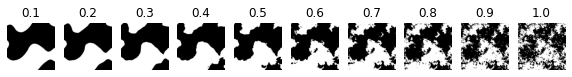

In [14]:
complexities = [0.1, 0.4, 0.8]
noise_levels = [0.5, 1, 2, 4, 8]
lambda_values = [0, 0.1, 0.2, 0.3, 0.4, 0.5]

image_paths = sorted(list(glob("../datasets/edge_complexity/gt/perlin_*_003.png")))
fig, axs = plt.subplots(1, 10, figsize=(10, 1))
for i, path in enumerate(image_paths):
    axs[i].imshow(plt.imread(path))
    axs[i].axis('off')
    axs[i].set_title(path.split('_')[-2])

(3, 5, 512, 512)


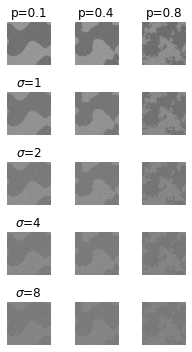

In [15]:
images = np.array([plt.imread(path)[:,:,0] for path in image_paths if float(path.split("/")[-1].split("_")[1]) in complexities])
def add_noise(image, amount=0.5, seed=None):
    image = skimage.util.random_noise(image, mode='gaussian', seed=seed, clip=False, var=amount)
    image = image - np.min(image)
    image = image / np.max(image)
    return image
noisy_images = np.array([[add_noise(image, amount=sigma, seed=0) for sigma in noise_levels] for image in images])
print(noisy_images.shape)
fig, axs = plt.subplots(len(noise_levels), len(complexities), figsize=(len(complexities), len(noise_levels)))
sigma = r'$\sigma$'
for row in range(noisy_images.shape[0]):
    for col in range(noisy_images.shape[1]):
        axs[col, row].imshow(noisy_images[row, col], cmap='gray')
        axs[col, row].axis('off')
        if row == 0 and col != 0:
            axs[col, row].set_title(f"{sigma}={noise_levels[col]}")
        if col == 0:
            axs[col, row].set_title(f"p={complexities[row]}")
plt.tight_layout()

In [16]:
def segment_and_save(paramset):
    d = paramset["d"]
    sigma = paramset["sigma"]
    p = paramset["p"]
    seed = paramset["seed"]
    bar = paramset["bar"]
    lambda_ = paramset["lambda_"]
    if os.path.exists(f"lambda_effects_noise_output/lambda_{lambda_:.1f}_sigma_{sigma:.1f}_p_{p:.1f}_seed_{seed:02d}.png"):
        bar.update(1)
        return
    im = noisy_images[paramset["p_index"], paramset["sigma_index"]]
    seg = GNEMS_segment(im, d=d, lambda_=lambda_,
            iterations=50, prediction_stride=8,
            slic_segments=100, sigma=3, show_progress=False, seed=seed)
    seg = Image.fromarray((seg * 255).astype(np.uint8)).convert('L')
    seg.save(f"lambda_effects_noise_output/lambda_{lambda_:.1f}_sigma_{sigma:.1f}_p_{p:.1f}_seed_{seed:02d}.png")
    bar.update(1)

seeds = list(range(1000))
paramsets = []
with tqdm.tqdm(total=noisy_images.shape[0] * noisy_images.shape[1] * len(lambda_values) * len(seeds)) as pbar:
    for lambda_ in lambda_values:
        for sigma_index, sigma in enumerate(noise_levels):
            for p_index, p in enumerate(complexities):
                for seed in seeds:
                        paramsets.append({"bar":pbar,"d":16, "sigma":sigma, "sigma_index":sigma_index, "p":p, "p_index":p_index, "lambda_":lambda_, "seed":seed})

    with concurrent.futures.ThreadPoolExecutor(max_workers=60) as executor:
        res = executor.map(segment_and_save, paramsets)
    for result in res:
        pass
            

100%|██████████| 90000/90000 [4:23:00<00:00,  5.70it/s]  


In [5]:
segmentation_paths = sorted(list(glob("lambda_effects_noise_output/*.png")))
lambdas = []
sigmas = []
ps = []
mious = []
for path in tqdm.tqdm(segmentation_paths):
    split_name = ".".join(path.split('/')[-1].split(".")[:-1]).split("_")
    lambda_ = float(split_name[1])
    sigma = float(split_name[3])
    p = float(split_name[5])
    gt_path = f"../datasets/edge_complexity/gt/perlin_{p:.1f}_003.png"
    gt = plt.imread(gt_path)[:,:,0]
    seg = plt.imread(path)
    miou = calculate_mIOU(seg, gt)
    lambdas.append(lambda_)
    sigmas.append(sigma)
    ps.append(p)
    mious.append(miou)

results = np.array([lambdas, sigmas, ps, mious]).T

with open("lambda_effects_noise_results.json", "w") as f:
    json.dump(results.tolist(), f)

100%|██████████| 30000/30000 [24:21<00:00, 20.53it/s]


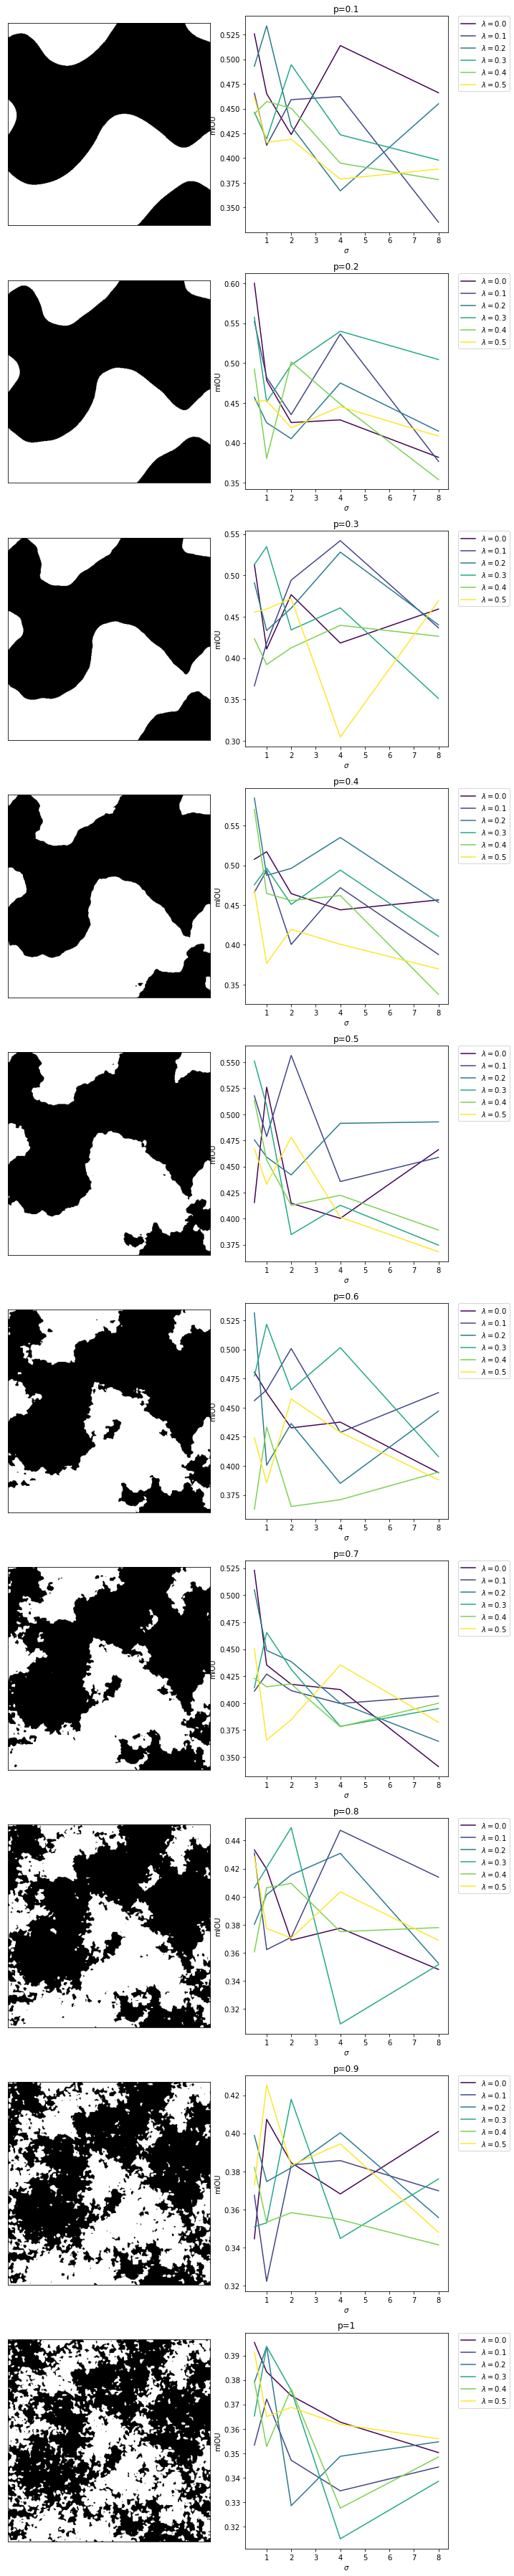

In [10]:
with open("lambda_effects_noise_results.json", "r") as f:
    results = np.array(json.load(f))

df = pd.DataFrame(results, columns=["lambda_", "sigma", "p", "mIOU"])
lambda_subset = lambda_values[:6]
colors = plt.cm.viridis(np.linspace(0, 1, len(lambda_subset)))
fig, axs = plt.subplots(10, 2, figsize=(10, 50))
for i, p in enumerate(complexities):
    df_p = df[df["p"] == p]
    for lambda_index, lambda_ in enumerate(np.unique(lambda_values)):
        df_lambda = df_p[df_p["lambda_"] == lambda_]
        d_sigmas = []
        d_mIOU_means = []
        d_mIOU_stds = []
        for sigma in np.unique(sigmas):
            df_sigma = df_lambda[df_lambda["sigma"] == sigma]
            d_sigmas.append(sigma)
            d_mIOU_means.append(df_sigma["mIOU"].mean())
            d_mIOU_stds.append(df_sigma["mIOU"].std())
        axs[i,1].plot(d_sigmas, d_mIOU_means, label=f"$\lambda={lambda_}$", color=colors[lambda_index])
    axs[i,1].set_title(f"p={p}")
    axs[i,1].set_xlabel(r"$\sigma$")
    axs[i,1].set_ylabel("mIOU")
    axs[i,1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    axs[i,0].imshow(plt.imread(f"../datasets/edge_complexity/gt/perlin_{p:.1f}_003.png")[:,:,0], cmap='gray')
    axs[i,0].set_xticks([])
    axs[i,0].set_yticks([])
plt.tight_layout()